<a href="https://colab.research.google.com/github/bustardchad/ML_Turb/blob/main/notebooks/Gaussian_allClasses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Analysis: Gaussian Filtering

Analyzes how a CNN trained to differentiate MHD-only vs MHD+cosmic ray images
classifies images that have been gaussian smoothed to varying extents.
As we'll see, this smoothing apparently mocks the effects of cosmic rays, which act as a drag force on
fluctuations, effectively smoothing out sharp density features.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import TensorDataset, random_split
import pdb
import os

import seaborn as sn
import pandas as pd

!pip install cmasher
!pip install torchmetrics

!pip install torchinfo
!pip install tensorboard
from torchinfo import summary

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.1/367.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 5.3 MB/s eta 0:00:00


'cpu'

In [6]:
# configuration for training
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    sim_type = 'classify'
    inference = True
    data_presplit = True # whether data has already been split into training, val, test
    fileDirArr = ['MHD_beta10', 'CR_Advect_beta10', 'CR_Diff_Fiducial_beta10', 'CR_Diff100_beta10', 'CR_withStreaming_beta10']
    #fileDirArr = ['MHD_beta10', 'CR_Diff_Fiducial_beta10']
    field_list = ['density']
    projection_depth = 1
    killPwr = False
    num_classes = 5
    train_frac = 0.6
    batch_size = 64
    use_transforms = False # add horizontal and vertical flipped versions
    epochs = 25
    stop_early = True
    patience = 5
    run_locally = True # if running on my computer, take files from local directory instead of downloading them
    run_colab = True
    path_to_dir = 'drive/MyDrive/Turb_Sims/Image_Cubes/Multiple_Snapshots_Small/Full_Power/'
    dataset_size = 'small'
    hold_out_test_set = True
    save_dir = 'runs/'
    run_name = 'MHD_CRTransport_KillPwr_allClasses_multiple_snapshots_small'

config = TrainingConfig()

In [3]:
# Download the relevant data from Google Drive
!pip install --upgrade --no-cache-dir gdown
import gdown

from google.colab import drive


if (config.run_locally==False):

    # Path for the FULL google drive file with turb sim data
    # url = "https://drive.google.com/drive/folders/1C9zPwEglOZI7CqiS4Rz2MESCJzS4wTd2"

    # Path for the smaller turb sim data files (without augmentation)
    #url = "https://drive.google.com/drive/folders/1YDXgeazcwfyciAGUv_sW-gHDy7e1k5wY"

    url = "https://drive.google.com/drive/folders/1zzwYNPSV42jyEQVErlbE-CyKGIustlHv"

    if config.killPwr:
      url = "https://drive.google.com/drive/folders/1B7N_x5Y1N0wH96vKubyQ86Oftaz2M8W9"


    #if not os.path.exists("Image_Cubes_noAugment"):
    gdown.download_folder(url)
else: # Access files on google drive directly
    drive.mount('/content/drive')

  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6
Mounted at /content/drive


In [4]:
# If on Google Colab, need to clone repo to have access to helper files

!git clone https://github.com/bustardchad/ML_Turb

import ML_Turb.utilities.load_data as load_data
import ML_Turb.utilities.interpret_CNN as interp
import ML_Turb.utilities.classify_setup as classify_setup

# load data
#train_dl, valid_dl, test_dl = load_data.preprocess(config)

Cloning into 'ML_Turb'...
remote: Enumerating objects: 429, done.
remote: Counting objects: 100% (85/85), done.
remote: Compressing objects: 100% (68/68), done.
remote: Total 429 (delta 49), reused 38 (delta 17), pack-reused 344
Receiving objects: 100% (429/429), 87.28 MiB | 19.68 MiB/s, done.
Resolving deltas: 100% (223/223), done.


mkdir: cannot create directory ‘runs’: File exists
Loading training file /train_MHD_beta10_density_small.npy for classification problem
Loading training file /train_CR_Advect_beta10_density_small.npy for classification problem
Loading training file /train_CR_Diff_Fiducial_beta10_density_small.npy for classification problem
Loading training file /train_CR_Diff100_beta10_density_small.npy for classification problem
Loading training file /train_CR_withStreaming_beta10_density_small.npy for classification problem


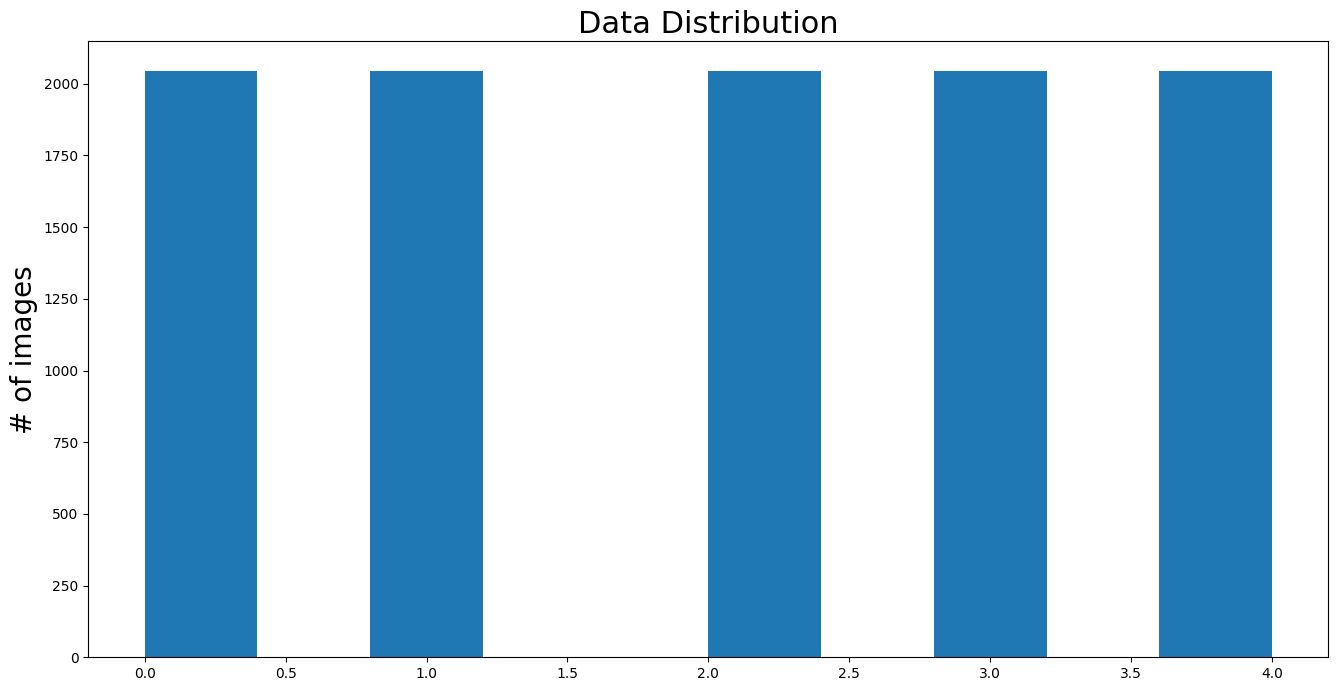

In [7]:
# Load data
torch.cuda.empty_cache()

# TODO: Log and store metrics and associated checkpoint files in folders
# TODO: Create a composite figure showing losses for different hyperparams

save_dir = 'runs/'
config.save_dir = save_dir
!mkdir 'runs'

batch_size = 64
config.batch_size = batch_size

# load data (this needs to be done in-loop when batch_size changes)
train_dl, valid_dl, test_dl = load_data.preprocess(config)

In [8]:
# structure of the saved model

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(8),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(64),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.AdaptiveAvgPool2d(4), # works with any input size
    nn.Flatten(),
    nn.Linear(64*4*4,config.num_classes)
)
"""

model = nn.Sequential(
    nn.Conv2d(1, 8, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(8),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(8, 16, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(16),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
    nn.BatchNorm2d(32),
    nn.SiLU(),
    nn.Dropout(0.25),
    nn.AdaptiveAvgPool2d(4), # works with any input size
    nn.Flatten(),
    nn.Linear(32*4*4,config.num_classes)
)

"""
# path to checkpoint file
path_to_chk = ''
checkpoint_filename = 'fullpwr_batch_size_64lr_0.001_pdrop_0.25_checkpoint.pt'
# load the saved model checkpoint
model.load_state_dict(torch.load(path_to_chk + checkpoint_filename,map_location=torch.device('cpu')))
model.eval()

Sequential(
  (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): SiLU()
  (3): Dropout(p=0.25, inplace=False)
  (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (5): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): SiLU()
  (7): Dropout(p=0.25, inplace=False)
  (8): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (9): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): SiLU()
  (11): Dropout(p=0.25, inplace=False)
  (12): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (13): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): SiLU()
  (15): Dropout(p=0.25, inplace=False)
  (16): AdaptiveAvgPool2d(output_size=4)
  (17): Flatten(start_dim=1, end_dim=-1)
  (18): Linear(in_features=1024, out_features=5, bias=Tr

<ipython-input-25-efcd7121845d>:7: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter


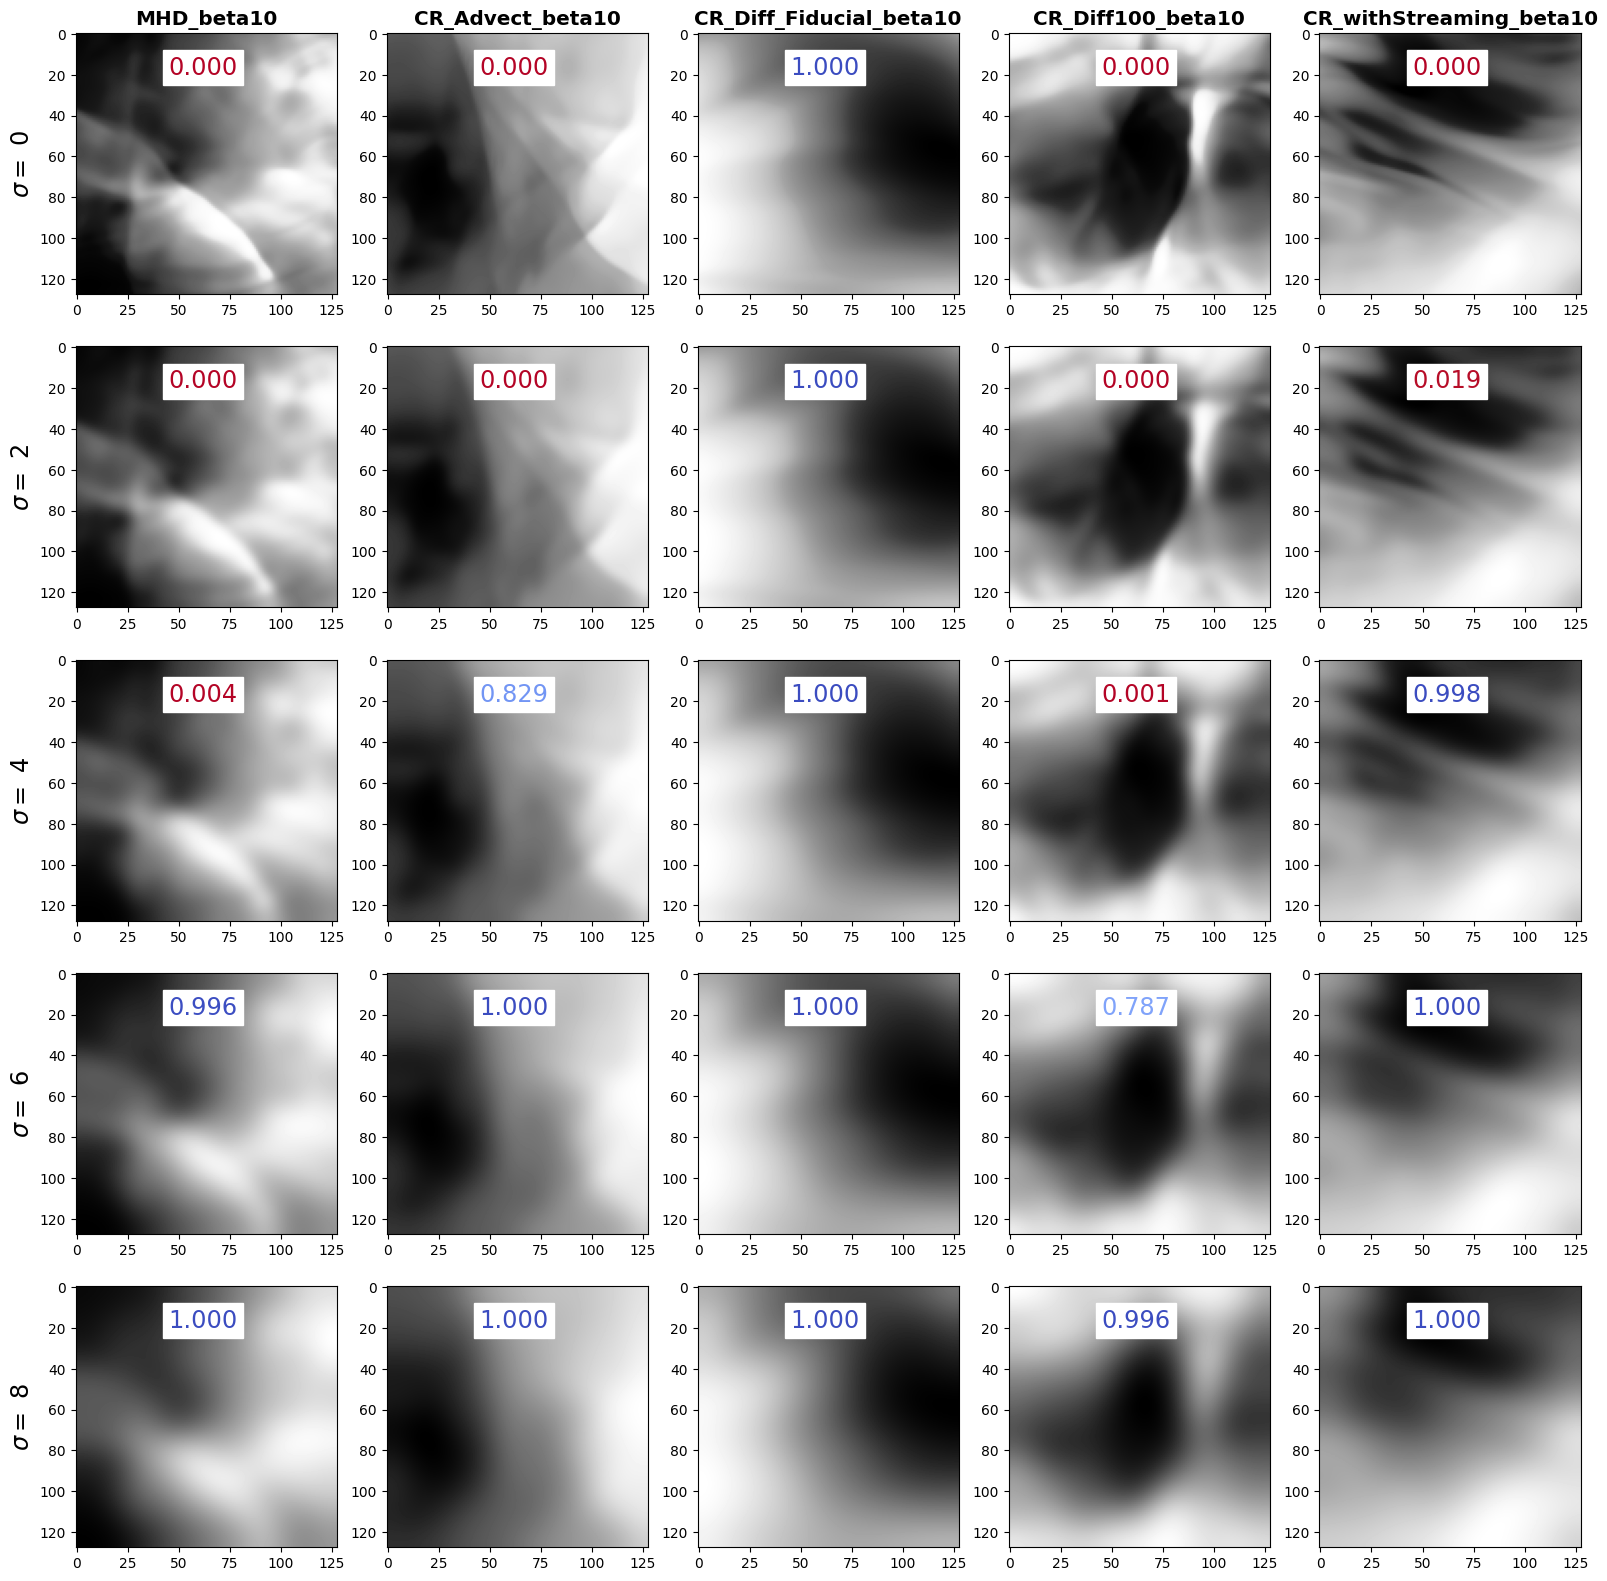

In [25]:
import matplotlib
from torchinfo.enums import RowSettings
# Show gaussian filtered images belonging to class sim_class and their power spectra
# Image titles are probability that the image belongs to sim_class
from ML_Turb.utilities.interpret_CNN import power1D

from scipy.ndimage.filters import gaussian_filter
import seaborn as sns

# MHD_beta10 == 0
# CR_Advect_beta10 == 1
# CR_Diff_Fiducial_beta10 == 2
# CR_Diff100_beta10 == 3
# CR_withStreaming_beta10 == 4

# which class to take images from and gaussian filter
# sim_class = 4

# which class to show probability of
prob_class = 2

n_examples = 5 # number of columns
n_sigmas = 5 # number of different sigmas

fig, axs = plt.subplots(n_sigmas, n_examples, figsize=(16,16))
#fig_spectra, axs_spectra = plt.subplots(n_sigmas, n_examples, figsize=(16,16))

# access a batch of labelled images
dataiter = iter(test_dl)
images, labels = next(dataiter)

# select n_example example images from each class
#k_norm, pwr_norm = power1D(images_to_plot[0,:,:,:]) # take FFT of 1st image in
                                              # batch with label == sim_class

# colormap for the probabilities
cnorm = matplotlib.colors.Normalize(vmin=0.01,vmax = 1,clip=True)
mapper = matplotlib.cm.ScalarMappable(norm=cnorm,cmap=matplotlib.cm.coolwarm_r)

for i in range(0,n_sigmas):
    for j in range(0,n_examples):
        images_to_plot = images[labels==j]
        #plt_image = images_to_plot[j,:,:,:]
        plt_image = images_to_plot[0,:,:,:]

        # apply a Gaussian filter with standard deviation sigma to the image
        plt_image = torch.from_numpy(gaussian_filter(plt_image,sigma=float(2*i)))

        # create 1D power spectrum of filtered image
        #k, pwr = power1D(plt_image)

        #run inference on modified image
        output = model(plt_image.reshape(1,1,plt_image.shape[-2],plt_image.shape[-1]))
        output = nn.functional.softmax(output, dim=1) # makes it a probability for each class

        all_probs = output.tolist()[0]
        prob = all_probs[int(prob_class)] # grab probability that it was classified as class prob_class

        axs[i,j].imshow(plt_image.squeeze(),cmap='gray')
        #ttl = '{:2f},{:2f}'.format([])
        #axs[i,j].set_title(all_probs[j])
        #axs[i,j].set_title('{:.3f}'.format(prob),color=mapper.to_rgba(prob),size='xx-large',pad=-8.0)
        axs[i,j].text(x=45,y=20,s='{:.3f}'.format(prob),color=mapper.to_rgba(prob),size='xx-large',backgroundcolor='w')
        #axs_spectra[i,j].loglog(k,pwr*(k**2)/(pwr_norm*(k_norm**2)),label=r"k$^{2}$P(k)dk")
        #axs_spectra[i,j].set_title('{:.3f}'.format(prob))
        #axs_spectra[i,j].set_xlim(1,30)
        #axs_spectra[i,j].set_ylim(1.E-1,2.0)

rows = [r'$\sigma =$ {}'.format(2*row) for row in range(0, n_sigmas)]

cols = config.fileDirArr
#new_rows = []
#for i in rows:
#    new_rows.extend(i)

for ax, col in zip(axs[0], cols):
    ax.set_title(col,color="k",pad=6.0,size='x-large',fontweight='semibold')

for ax, row in zip(axs[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='xx-large')

fig.tight_layout()
#fig_spectra.tight_layout()
#plt.legend()
plt.savefig("Gaussian_Filter_allClasses_ProbFiducialDiff_coloredProbs.pdf", dpi=600)
plt.show()

We see that, with increased filtering of the images, they are more and more classified as CR_Diff_Fiducial_beta10, showing that the network distinguishes that class by its "blurriness" and its lack of small-scale structure

Let's go one step further and plot the 1D power spectra for some simulations

<ipython-input-37-761062d05100>:4: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
<ipython-input-37-761062d05100>:54: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cmap,label="P(CR_Diff_Fiducial_beta10)")


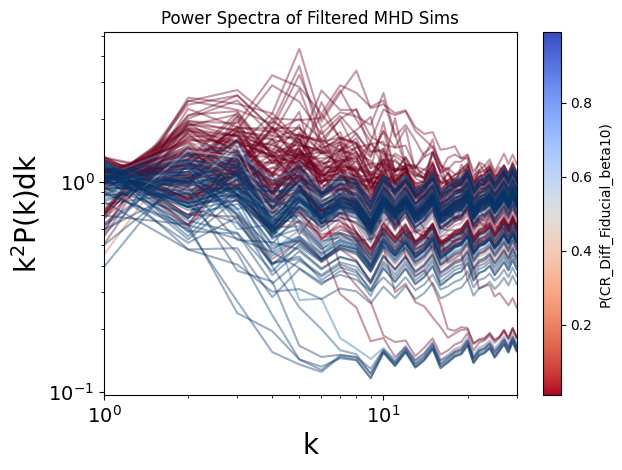

In [37]:
# make spectra for filtered images and color them by probabilities

import matplotlib as mpl
from scipy.ndimage.filters import gaussian_filter
import seaborn as sns

# which class to calculate probability of
sim_class = 2

n_examples = 6 # number of columns
n_sigmas = 6 # number of different sigmas

# access a batch of labelled images
dataiter = iter(test_dl)
images, labels = next(dataiter)

images_class0 = images[labels==0]

cvals = np.arange(1.E-2,1.0,1.E-2)
colors = plt.cm.RdBu(cvals)

norm = mpl.colors.Normalize(vmin=cvals.min(), vmax=cvals.max())
cmap = mpl.cm.ScalarMappable(norm=norm, cmap=mpl.cm.coolwarm_r)
cmap.set_array([])



fig, axs = plt.subplots()

for i in range(0,n_sigmas):
    for j in range(0,len(images_class0)):
        plt_image = images_class0[j,:,:,:]

        # apply a Gaussian filter with standard deviation sigma to the image
        plt_image = torch.from_numpy(gaussian_filter(plt_image,sigma=float(2*i)))

       # create 1D power spectrum of filtered image
        k, pwr = power1D(plt_image)

        #run inference on modified image
        output = model(plt_image.reshape(1,1,plt_image.shape[-2],plt_image.shape[-1]))
        output = nn.functional.softmax(output, dim=1) # makes it a probability for each class

        prob = output.tolist()[0][int(sim_class)] # grab probability that it was classified as class sim_class

        axs.loglog(k,pwr*(k**2)/1e7,label=r"k$^{2}$P(k)dk",color=colors[np.abs(cvals-prob).argmin()],alpha=0.4)

plt.xlim(1,30)
plt.ylabel(r"k$^{2}$P(k)dk",fontsize=20)
plt.xlabel("k",fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title("Power Spectra of Filtered MHD Sims")
fig.colorbar(cmap,label="P(CR_Diff_Fiducial_beta10)")

plt.tight_layout()
#plt.legend()
plt.savefig("Prob_Filtered_Spectra.pdf",dpi=600)
plt.show()
plt.close()